## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.7.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 10320 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

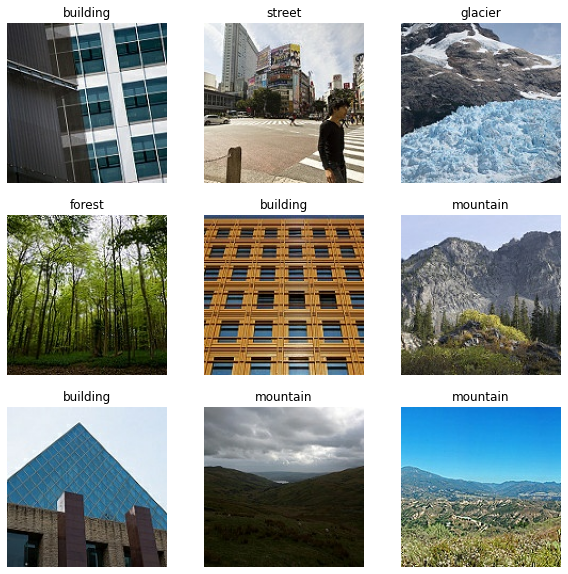

In [6]:
class_names = training_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

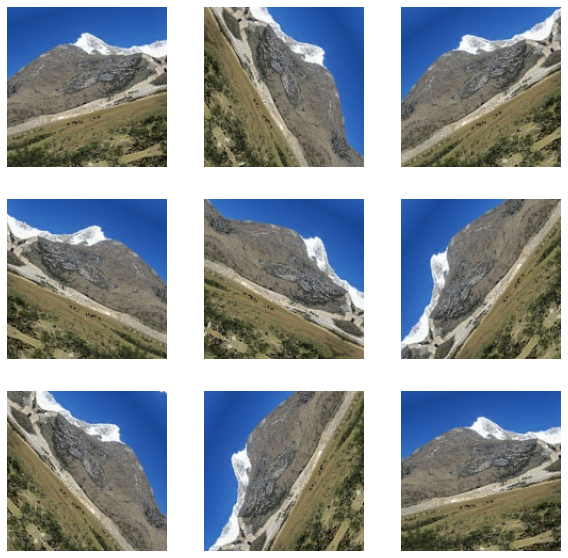

In [8]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development And Training

### Rescale pixel values

We will use `tf.keras.applications.DenseNet121` as our base model.

In [9]:
preprocess_input = tf.keras.applications.densenet.preprocess_input

### Creation of the base model using a CNN architecture

In [10]:
# Create the base model from the pre-trained model DenseNet121
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 156, 156, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 75, 75, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [13]:
prediction_layer = tf.keras.layers.Dense(len(class_names))

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [14]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [15]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = opt,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 150, 150, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0     

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 62s 735ms/step - loss: 2.4750 - accuracy: 0.1911
initial loss: 2.47
initial accuracy: 0.19


### Model training

In [18]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
323/323 [==============================] - 318s 964ms/step - loss: 1.6137 - accuracy: 0.4139 - val_loss: 0.9418 - val_accuracy: 0.6329
Epoch 2/10
323/323 [==============================] - 303s 939ms/step - loss: 0.8998 - accuracy: 0.6545 - val_loss: 0.6060 - val_accuracy: 0.7899
Epoch 3/10
323/323 [==============================] - 304s 941ms/step - loss: 0.6774 - accuracy: 0.7459 - val_loss: 0.4810 - val_accuracy: 0.8341
Epoch 4/10
323/323 [==============================] - 303s 938ms/step - loss: 0.5726 - accuracy: 0.7909 - val_loss: 0.4188 - val_accuracy: 0.8550
Epoch 5/10
323/323 [==============================] - 302s 935ms/step - loss: 0.5189 - accuracy: 0.8022 - val_loss: 0.3819 - val_accuracy: 0.8636
Epoch 6/10
323/323 [==============================] - 301s 933ms/step - loss: 0.4698 - accuracy: 0.8264 - val_loss: 0.3554 - val_accuracy: 0.8760
Epoch 7/10
323/323 [==============================] - 302s 934ms/step - loss: 0.4538 - accuracy: 0.8313 - val_loss: 0.3387 -

In [19]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model (Fine tuning)

In [20]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 150, 150, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 150, 150, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 150, 150, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0     

### Continue training and save the model

In [22]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

history = model.fit(training_dataset,
                    epochs=total_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset)

Epoch 10/20
323/323 [==============================] - 729s 2s/step - loss: 0.3429 - accuracy: 0.8779 - val_loss: 0.2611 - val_accuracy: 0.9112
Epoch 11/20
323/323 [==============================] - 743s 2s/step - loss: 0.2813 - accuracy: 0.8984 - val_loss: 0.2241 - val_accuracy: 0.9233
Epoch 12/20
323/323 [==============================] - 818s 3s/step - loss: 0.2479 - accuracy: 0.9136 - val_loss: 0.2158 - val_accuracy: 0.9283
Epoch 13/20
323/323 [==============================] - 963s 3s/step - loss: 0.2278 - accuracy: 0.9185 - val_loss: 0.2029 - val_accuracy: 0.9283
Epoch 14/20
323/323 [==============================] - 949s 3s/step - loss: 0.2114 - accuracy: 0.9252 - val_loss: 0.2045 - val_accuracy: 0.9279
Epoch 15/20
323/323 [==============================] - 932s 3s/step - loss: 0.1973 - accuracy: 0.9306 - val_loss: 0.2021 - val_accuracy: 0.9314
Epoch 16/20
323/323 [==============================] - 1635s 5s/step - loss: 0.1809 - accuracy: 0.9366 - val_loss: 0.2050 - val_accuracy

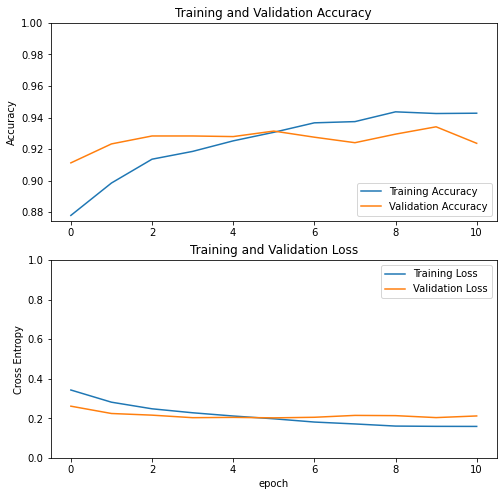

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save the model

In [24]:
model.save('../SavedModel/')

INFO:tensorflow:Assets written to: ../SavedModel/assets


In [25]:
# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
with open('../static/model/model.tflite', 'wb') as file:
    file.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\fagai\AppData\Local\Temp\tmpzrw9ky6d\assets
